In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
taxable_income_dat = pd.read_csv('../../geodata/data/25887_131_swiss_average_income_2018_for_script.csv')
taxable_income_dat.columns = ['Regions-ID','Regionsname','taxable_income','taxable_income_ptp']

net_income_dat = pd.read_csv('../../geodata/data/25887_131_swiss_average_income_2018_for_script.csv')
net_income_dat.columns = ['Regions-ID','Regionsname','net_income','net_income_ptp']

In [3]:
income_dat = pd.merge(left = net_income_dat, right = taxable_income_dat, on = ['Regions-ID','Regionsname'])

In [4]:
income_dat = (income_dat.assign(
    taxable_income = lambda x: pd.to_numeric(x.taxable_income.
                                             replace('X',0).str.replace(',',''), errors='ignore'),
    taxable_income_ptp = lambda x: pd.to_numeric(x.taxable_income_ptp.
                                                 replace('X',0).str.replace(',',''), errors='ignore'),
    net_income = lambda x: pd.to_numeric(x.net_income.
                                         replace('X',0).str.replace(',',''), errors='ignore'),
    net_income_ptp = lambda x: pd.to_numeric(x.net_income_ptp.
                                             replace('X',0).str.replace(',',''), errors='ignore')))



In [5]:
income_dat['deductions'] = income_dat.net_income - income_dat.taxable_income
income_dat['deductions_ptp'] = income_dat.net_income_ptp - income_dat.taxable_income_ptp

In [22]:
#IMPORT ADMINISTRATION BOUNDARIES
ch_g2g18  = gpd.read_file('../../geodata/ch_districts/ch_districts_g2g18.gpkg')
ch_lakes = gpd.read_file('../../geodata/ch_lakes/ch_lakes.gpkg')

In [8]:
income_dat['Regionsname'] = income_dat.Regionsname.replace('La Grande Béroche','La Grande-Béroche')
ch_muni = pd.merge(left = ch_g2g18, right = income_dat, left_on = 'GMDNAME', right_on = 'Regionsname')
ch_muni = ch_muni.assign(deductPCT = ch_muni.deductions_ptp / ch_muni.net_income_ptp)

In [9]:
ch_muni.to_file('../../geodata/ch_districts/ch_income_per_commune_2018.gpkg', driver = 'GPKG')

(2468003.35, 2851257.65, 1052459.95909, 1309244.7381100003)

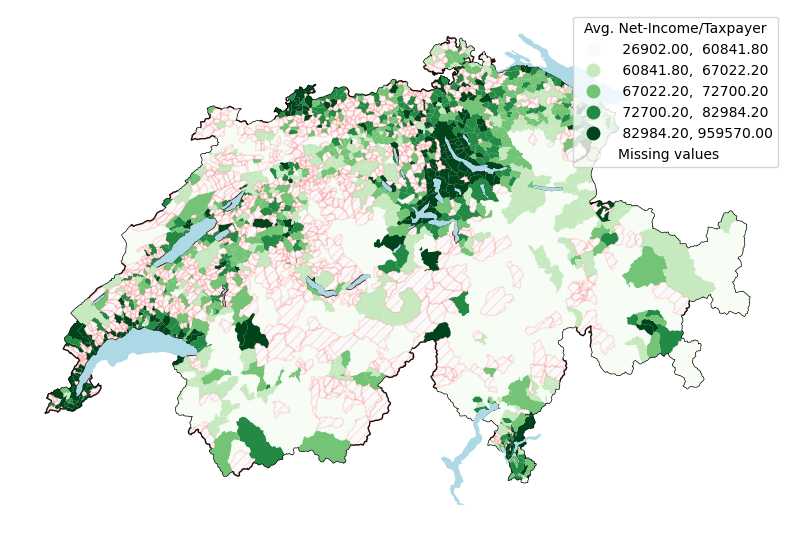

In [34]:
import mapclassify as mc
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize = (10,10))
ch_muni.dissolve().plot(facecolor = 'none', edgecolor = 'black', ax =ax)
ch_lakes.dissolve().plot(color = 'lightblue', ax = ax)
ch_muni.plot('net_income_ptp', 
             cmap = 'Greens', 
             scheme = 'quantiles', 
             legend = True,
             missing_kwds={"color": "lightgrey",
                           "edgecolor": "red",
                           "hatch": "///",
                           "label": "Missing values",
                           "alpha": .1
                           },
            ax = ax)
ax.get_legend().set_title("Avg. Net-Income/Taxpayer")
plt.axis('off')